purpose: identify rat and human only subnetworks networks for the loco-ext network and compare to the BMI paper's combined species-enriched approach.

# set-up

Note: functions are at bottom of notebook- run first

In [1]:
import os
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from plotting_functions import *
from network_validation_functions import *

In [2]:
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
from matplotlib_venn import venn3, venn2

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
random_seed=random.seed(211)

In [5]:
save_fig=False

In [6]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


In [7]:
plt.rcParams.update({'font.size': 16})

# functions

In [8]:
def plt_scatter_NPS(tblr, tblc, tblr_label, tblc_label, tblr_seed, tblc_seed,
                    colour_r=colour_dict['loco'], colour_c=colour_dict['ext'], colour_shared=colour_dict['shared'],colour_nonseed=colour_dict['shared'],
                    tblr_lim=1.5, tblc_lim=1.5, comb_lim=3, savefig=False, filename='scatter_NPS'):
    """
    Visualizes the NPScommon and NPSrare scores as a scatter plot with and without seed genes

    The function generates four plots in a single figure: two histograms of NPScommon and NPS rare with and without seed genes,
    a combined histogram of NPScommon-rare, and a scatter plot of combined scores with network threshold lines,
    where NPSrare is plotted on the x-axis and NPScommon is plotted on the y-axis.

    Parameters:
    - tblr (DataFrame): DataFrame containing NPSrare.
    - tblc (DataFrame): DataFrame containing NPScommon.
    - tblr_label (str): Label for rare trait, used in the Venn diagram.
    - tblc_label (str): Label for common trait, used in the Venn diagram.
    - tblr_seed (list of str): A list of rare seed genes.
    - tblc_seed (list of str): A list of common seed genes.
    - tblr_lim (float, optional): The NPSrare cutoff. Defaults to 1.5.
    - tblc_lim (float, optional): The NPScommon cutoff. Defaults to 1.5.
    - comb_lim (float, optional): The NPScommon-rare. Defaults to 3.
    - savefig (bool, optional): If True, saves the plot as an SVG file in a predefined directory. Defaults to False.

    Returns:
    None
    """
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12.5, 5))

    # Combine zscore tables
    tbl_z = pd.concat([tblr, tblc], axis=1)
    tbl_z.columns = ('z1', 'z2')
    tbl_z['z_comb'] = tbl_z['z1'] * tbl_z['z2']

    # Separate in-network and out-network data
    inNetwork = tbl_z[(tbl_z['z1'] > tblr_lim) & (tbl_z['z2'] > tblc_lim) & (tbl_z['z_comb'] > comb_lim)]
    outNetwork = tbl_z[(tbl_z['z1'] <= tblr_lim) | (tbl_z['z2'] <= tblc_lim) | (tbl_z['z_comb'] <= comb_lim)]
    seedInNetwork = inNetwork[(~inNetwork.index.isin(tblr_seed)) & (~inNetwork.index.isin(tblc_seed))]

    # Plot with seed genes
    ax1.scatter(x=outNetwork['z1'], y=outNetwork['z2'], s=1, color=color_dict['other'],label='non-network genes')
    ax1.scatter(x=inNetwork['z1'], y=inNetwork['z2'], s=1, color=colour_nonseed,label='network seed genes')
    ax1.scatter(x=seedInNetwork['z1'], y=seedInNetwork['z2'], s=1, color=colour_shared,label='network genes')


    # Set labels and lines for ax1
    ax1.set_xlabel(tblr_label)
    ax1.set_ylabel(tblc_label)
    ax1.axvline(x=tblr_lim, color=colour_r, linestyle='dashed', linewidth=1,label='NPSr')
    ax1.axhline(y=tblc_lim, color=colour_c, linestyle='dashed', linewidth=1,label='NPSh')
    x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
    combo_line = [comb_lim / x for x in x_points if x > comb_lim / 50]
    ax1.plot([x for x in x_points if x > comb_lim / 40], combo_line, color=colour_shared, linestyle='dashed', linewidth=1,label='NPSrh')
    ax1.axvline(x=0, color='black', linestyle='solid', linewidth=1)
    ax1.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    ax1.legend(loc='center right', bbox_to_anchor=(2.75, 0.5))

    
    # Filter out seed genes
    tbl_z = tbl_z[(~tbl_z.index.isin(tblr_seed)) & (~tbl_z.index.isin(tblc_seed))]
    inNetwork = tbl_z[(tbl_z['z1'] > tblr_lim) & (tbl_z['z2'] > tblc_lim) & (tbl_z['z_comb'] > comb_lim)]
    outNetwork = tbl_z[(tbl_z['z1'] <= tblr_lim) | (tbl_z['z2'] <= tblc_lim) | (tbl_z['z_comb'] <= comb_lim)]

    # Plot without seed genes
    ax2.scatter(x=outNetwork['z1'], y=outNetwork['z2'], s=1, color=color_dict['other'])
    ax2.scatter(x=inNetwork['z1'], y=inNetwork['z2'], s=1, color=colour_shared)

    # Set labels and lines for ax2
    ax2.set_xlabel(tblr_label)
    ax2.set_ylabel(tblc_label)
    ax2.axvline(x=tblr_lim, color=colour_r, linestyle='dashed', linewidth=1)
    ax2.axhline(y=tblc_lim, color=colour_c, linestyle='dashed', linewidth=1)
    x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
    combo_line = [comb_lim / x for x in x_points if x > comb_lim / 50]
    ax2.plot([x for x in x_points if x > comb_lim / 40], combo_line, color=colour_shared, linestyle='dashed', linewidth=1)
    ax2.axvline(x=0, color='black', linestyle='solid', linewidth=1)
    ax2.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    ax2.set_xlim([min(tbl_z['z1'])-.5, max(tbl_z['z1'])+.5])
    ax2.set_ylim([min(tbl_z['z2'])-.5, max(tbl_z['z2'])+.5])

    # Save the figure if requested
    if savefig:
        plt.savefig('figures/' + filename + '.svg', bbox_inches='tight')

    # Display the plot
    plt.show()


In [9]:
#straight from BMI network notebook 3

def sub_graph(data, rat_th_dict, human_th_dict, conserved_th_dict):
    """Wrapper function to assign each gene in data to a subnetwork based on the thresholds defined

    Args:
        data (pandas.DataFrame): DataFrame containing the genes and their NPS scores
        rat_th_dict (dict): A dictionary specifying the three thresholds to define the rat-Specific network
        human_th_dict (dict): A dictionary specifying the three thresholds to define the human-Specific network
        conserved_th_dict (dict): A dictionary specifying the three thresholds to define the conserved network

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for all subnetworks
    """
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    else:
        data["subgraph"] = "PCNet"
    data = assign_sub_graph(data, th_dict = conserved_th_dict, name="conserved")
    data = assign_sub_graph(data, th_dict = rat_th_dict, name="rat")
    data = assign_sub_graph(data, th_dict = human_th_dict, name="human")
    return data

def assign_sub_graph(data, rat_th=None, human_th=None, combo_th=None, th_dict=None, name="conserved"):
    """Assigns sub_graph annotations based on input thresholds

    Args:
        data (pd.DataFrame): Dataframe containing the NPS scores for all genes
        rat_th (dict, optional): If assigning the rat-Specific network, rat-Specific thresholds. Defaults to None.
        human_th (dict, optional): If assigning the human-Specific network, human-Specific thresholds. Defaults to None.
        combo_th (dict, optional): If assigning the conserved network, conserved thresholds. Defaults to None.
        th_dict (dict, optional): Dictionary of all thresholds.  Defaults to None.
        name (str, optional): Name of the subgraph being assigned. Defaults to "conserved".

    Returns:
        pandas.DataFrame: The input data set with a new/updated subgraph column for a single subnetwork
    """
    if th_dict is not None:
        rat_th = th_dict["rat"]
        combo_th = th_dict["combo"]
        human_th = th_dict["human"]
    if "subgraph" not in data.columns:
        data = data.assign(subgraph="PCNet")
    if name == "rat":
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h < human_th) & (data.NPS_r * (data.NPS_h - 1) < combo_th)), 
                ("subgraph")] = "Rat-Specific"
    elif name == "human":
        data.loc[((data.NPS_r < rat_th) & (data.NPS_h > human_th) & ((data.NPS_r - 1)*(data.NPS_h) < combo_th)), 
                ("subgraph")] = "Human-Specific"
    else:
        data.loc[((data.NPS_r > rat_th) & (data.NPS_h > human_th) & (data.NPS_hr > combo_th)), ("subgraph")] = "Conserved"
    return data

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [8]:
interactome_name='PCNet2.0'
tissue_network=False

In [9]:
if tissue_network==False:
    if interactome_name=='PCNet2.0':
        all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
    else:
        interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
        all_nodes=list(interactome.nodes())
else:
    netdir='tissue_networks/intermediate/'
    tissue='global'
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]

# import NPS scores and seed genes

In [10]:
seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,all_nodes)

In [11]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)
NPS_dict.keys()

dict_keys(['loco_bonf_PCNet2.0', 'loco_top500_PCNet2.0', 'loco_FDR_PCNet2.0', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_top500_PCNet2.0', 'loco_gsem_FDR_PCNet2.0', 'ext_bonf_PCNet2.0', 'ext_top500_PCNet2.0', 'ext_FDR_PCNet2.0', 'ext_st22_PCNet2.0', 'loco_mega_fus_naac_bonf_PCNet2.0', 'loco_mega_fus_naac_top500_PCNet2.0', 'loco_mega_fus_naac_FDR_PCNet2.0', 'ext_fus_naac_bonf_PCNet2.0', 'ext_fus_naac_top500_PCNet2.0', 'ext_fus_naac_FDR_PCNet2.0', 'loco_final_cf_bonf_PCNet2.0', 'loco_final_cf_top500_PCNet2.0', 'loco_final_cf_FDR_PCNet2.0', 'loco_final_mega_bonf_PCNet2.0', 'loco_final_mega_top500_PCNet2.0', 'loco_final_mega_FDR_PCNet2.0', 'ext_rat_bonf_PCNet2.0', 'ext_rat_top500_PCNet2.0', 'ext_rat_FDR_PCNet2.0', 'loco_final_cf_rat_bonf_PCNet2.0', 'loco_final_cf_rat_top500_PCNet2.0', 'loco_final_cf_rat_FDR_PCNet2.0', 'ext_db_bonf_PCNet2.0', 'ext_db_top500_PCNet2.0', 'ext_db_FDR_PCNet2.0', 'ext_rtb_bonf_PCNet2.0', 'ext_rtb_top500_PCNet2.0', 'ext_rtb_FDR_PCNet2.0', 'loco_final_cf_25_bonf_PCNet2.

# choose datasets for analysis

In [12]:
#modify for correct genesets
trait_r='loco_final_cf'
cut_r= 'FDR'

trait_h='ext'
cut_h='top500'


In [13]:
label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

In [14]:
tbl_z = pd.concat([NPS_r, NPS_h], axis=1)
tbl_z.columns = ('NPS_r', 'NPS_h')
tbl_z['NPS_hr'] = tbl_z['NPS_r'] * tbl_z['NPS_h']

# subset table for graphing

In [15]:
#subset table for just those inside and outside of the colocalized network
outNetwork = tbl_z[(tbl_z['NPS_r'] <= cut_single) 
| (tbl_z['NPS_h'] <= cut_single) 
| (tbl_z['NPS_hr'] <= cut_comb)]
inNetwork = tbl_z[(tbl_z['NPS_r'] > cut_single) 
& (tbl_z['NPS_h'] > cut_single) 
& (tbl_z['NPS_hr'] > cut_comb)]
seeds_r=tbl_z.filter(items=list(seed_r), axis=0)
seeds_h=tbl_z.filter(items=list(seed_h), axis=0)
seeds_hr=tbl_z.filter(items=list(set(seed_r).intersection(seed_h)), axis=0)

In [16]:
len(inNetwork)

263

# define rat-only network

In [17]:
cut_hm_specific

{'zr': 0, 'zh': 3, 'zhr': 0}

In [21]:
rat_only=outNetwork.nlargest(len(inNetwork),'NPS_r')

In [46]:
#CLASSIC METHOD- choose cutoffs to remove non-rat only nodes
#rat_only=outNetwork[(outNetwork['NPS_r'] > 3) & (outNetwork['NPS_h'] < 1.5)]
rat_only=tbl_z[(tbl_z['NPS_r'] > cut_rat_specific['zr']) 
& (tbl_z['NPS_h'] < cut_rat_specific['zh']) 
&(tbl_z['NPS_hr']<cut_rat_specific['zhr']) ]

In [92]:
#more lenient- remove the nodes
ratrat_only=tbl_z[(tbl_z['NPS_r'] > 3)]_only=outNetwork[(outNetwork['NPS_r'] > 3)]

In [41]:
rat_only['NPS_h'].describe()

count    500.000000
mean       0.166528
std        2.285479
min       -2.999908
25%       -0.873500
50%       -0.230439
75%        0.558940
max       26.315212
Name: NPS_h, dtype: float64

(array([282., 196.,  13.,   2.,   2.,   2.,   1.,   1.,   0.,   1.]),
 array([-2.99990833, -0.06839632,  2.86311569,  5.7946277 ,  8.72613972,
        11.65765173, 14.58916374, 17.52067575, 20.45218776, 23.38369977,
        26.31521179]),
 <BarContainer object of 10 artists>)

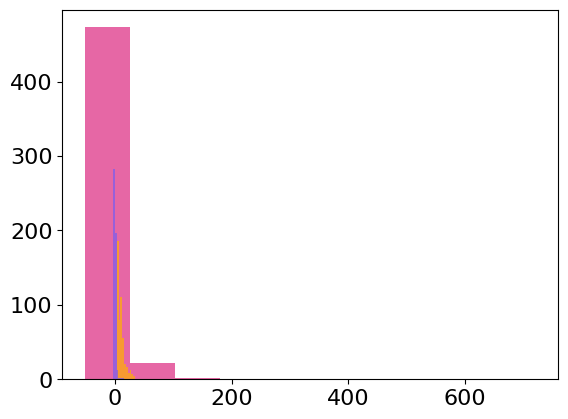

In [42]:
plt.hist(rat_only['NPS_hr'],alpha=0.7, color=colour_dict['shared'])
plt.hist(rat_only['NPS_r'],alpha=0.7, color=colour_dict['loco'])
plt.hist(rat_only['NPS_h'],alpha=0.7, color=colour_dict['ext'])

In [22]:
print("number of human seed genes in rat-only network: "+str(len(rat_only.filter(items=list(seed_h), axis=0))))

number of human seed genes in rat-only network: 0


In [23]:
print("portion of rat seed genes in rat-only network: "+str(len(rat_only.filter(items=list(seed_r), axis=0))/len(rat_only)))

portion of rat seed genes in rat-only network: 1.0


# define human only

In [25]:
cut_hm_specific

{'zr': 0, 'zh': 3, 'zhr': 0}

In [24]:
#hm_only=outNetwork.nlargest(len(inNetwork),'NPS_h')

In [49]:
#hm_only=outNetwork[(outNetwork['NPS_h'] > 3) & (outNetwork['NPS_r'] < 1.5)]
hm_only=tbl_z[
(tbl_z['NPS_h'] > cut_hm_specific['zh']) 
& (tbl_z['NPS_r'] < cut_hm_specific['zr'])
&(tbl_z['NPS_hr']< cut_hm_specific['zhr']) ]

In [27]:
#hm_only=outNetwork[(outNetwork['NPS_h'] > 3) & (outNetwork['NPS_r'] < 1.5)]

#hm_only=tbl_z[(tbl_z['NPS_h'] > cut_hm_specific['zh'])]

In [76]:
#hm_only=outNetwork[(outNetwork['NPS_h'] > 3) & (outNetwork['NPS_r'] < 1.5)]
hm_only=tbl_z[(tbl_z['NPS_h'] > 3)]

In [93]:
hm_only=outNetwork[(outNetwork['NPS_h'] > 3)]

In [50]:
hm_only['NPS_r'].describe()

count    420.000000
mean      -0.660708
std        0.422788
min       -2.100090
25%       -0.905324
50%       -0.607762
75%       -0.316431
max       -0.002336
Name: NPS_r, dtype: float64

In [51]:
hm_only['NPS_h'].describe()

count    420.000000
mean       9.390412
std        5.774267
min        3.000058
25%        3.958667
50%        8.404469
75%       12.842046
max       31.046360
Name: NPS_h, dtype: float64

(array([ 95., 125.,  98.,  47.,  22.,  16.,  15.,   3.,   1.,   5.]),
 array([ 6.00633694,  8.77664045, 11.54694396, 14.31724748, 17.08755099,
        19.8578545 , 22.62815801, 25.39846152, 28.16876503, 30.93906854,
        33.70937206]),
 <BarContainer object of 10 artists>)

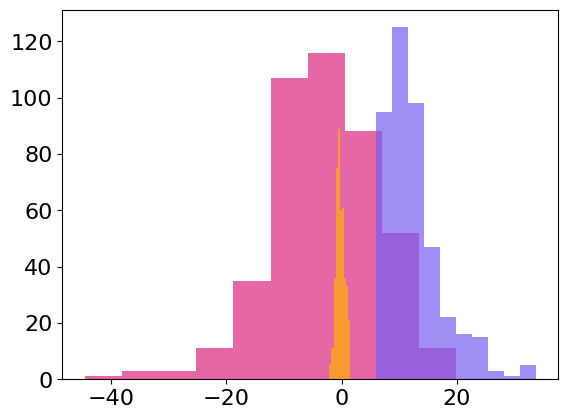

In [89]:
plt.hist(hm_only['NPS_hr'],alpha=0.7, color=colour_dict['shared'])
plt.hist(hm_only['NPS_r'],alpha=0.7, color=colour_dict['loco'])
plt.hist(hm_only['NPS_h'],alpha=0.7, color=colour_dict['ext'])

In [90]:
print("number of rat seed genes in human-only network: "+str(len(hm_only.filter(items=list(seed_r), axis=0))))

number of rat seed genes in human-only network: 0


In [25]:
print("portion of of human seed genes in human-only network: "+str(len(hm_only.filter(items=list(seed_h), axis=0))/len(hm_only)))

portion of of human seed genes in human-only network: 1.0


In [55]:
save_fig=True

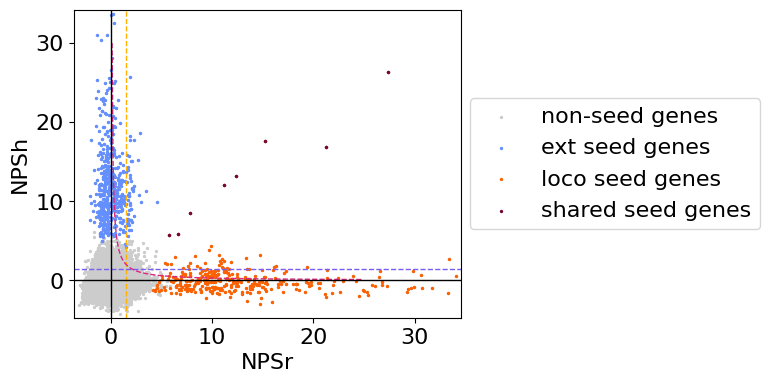

In [35]:
plt.figure(figsize=(5, 4))
plt.scatter(x=tbl_z['NPS_r'], y=tbl_z['NPS_h'], s=2, color=colour_dict['other'],label='non-seed genes')
#plt.scatter(x=inNetwork['NPS_r'], y=inNetwork['NPS_h'], s=1, color=colour_dict['shared'],label='network genes')
#plt.scatter(x=hm_only['NPS_r'], y=hm_only['NPS_h'], s=1, color=colour_dict['ext'],label='ext network genes')
#plt.scatter(x=rat_only['NPS_r'], y=rat_only['NPS_h'], s=1, color=colour_dict['loco'],label='loco network genes')
plt.scatter(x=seeds_h['NPS_r'], y=seeds_h['NPS_h'], s=2, color=colour_dict['ext_alt'],label='ext seed genes')
plt.scatter(x=seeds_r['NPS_r'], y=seeds_r['NPS_h'], s=2, color=colour_dict['loco_alt'],label='loco seed genes')
plt.scatter(x=seeds_hr['NPS_r'], y=seeds_hr['NPS_h'], s=2, color=colour_dict['shared_alt'],label='shared seed genes')


# Set labels and lines for plt
plt.xlabel('NPSr')
plt.ylabel('NPSh')
plt.axvline(x=1.5, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
plt.axhline(y=1.5, color=colour_dict['ext'], linestyle='dashed', linewidth=1)

#plt.axvline(x=3, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axhline(y=3, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#plt.set_aspect('equal', 'box')

x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
combo_line = [3 / x for x in x_points if x > 3 / 50]
plt.plot([x for x in x_points if x > 3 / 40], combo_line, color=colour_dict['shared'], linestyle='dashed', linewidth=1)
plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlim([min(tbl_z['NPS_r'])-.5, max(tbl_z['NPS_r'])+.5])
plt.ylim([min(tbl_z['NPS_h'])-.5, max(tbl_z['NPS_h'])+.5])
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
if save_fig:
    plt.savefig('figures/scatter_seedgene_dist_'+label_r+'_'+label_h+'.svg',bbox_inches='tight')


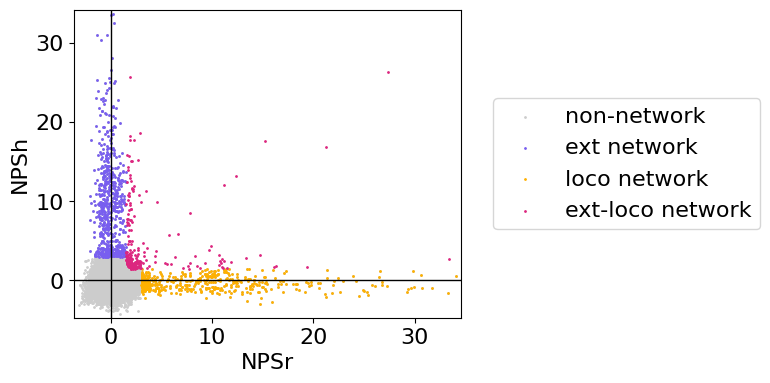

In [94]:
plt.figure(figsize=(5, 4))

plt.scatter(x=outNetwork['NPS_r'], y=outNetwork['NPS_h'], s=1, color=colour_dict['other'],label='non-network')
plt.scatter(x=hm_only['NPS_r'], y=hm_only['NPS_h'], s=1, color=colour_dict['ext'],label='ext network')
plt.scatter(x=rat_only['NPS_r'], y=rat_only['NPS_h'], s=1, color=colour_dict['loco'],label='loco network')
plt.scatter(x=inNetwork['NPS_r'], y=inNetwork['NPS_h'], s=1, color=colour_dict['shared'],label='ext-loco network')

#plt.scatter(x=seeds_h['NPS_r'], y=seeds_h['NPS_h'], s=1, color=colour_dict['ext_alt'],label='ext seed genes')
#plt.scatter(x=seeds_r['NPS_r'], y=seeds_r['NPS_h'], s=1, color=colour_dict['loco_alt'],label='loco seed genes')
#plt.scatter(x=seeds_hr['NPS_r'], y=seeds_hr['NPS_h'], s=1, color=colour_dict['shared_alt'],label='shared seed genes')


# Set labels and lines for plt
plt.xlabel('NPSr')
plt.ylabel('NPSh')
#plt.axvline(x=1.5, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axvline(x=3, color=colour_dict['loco'], linestyle='dashed', linewidth=1)
#plt.axhline(y=1.5, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#plt.axhline(y=3, color=colour_dict['ext'], linestyle='dashed', linewidth=1)
#x_points = [(i + 0.0001) / 10 for i in range(-50, 250)]
#combo_line = [3 / x for x in x_points if x > 3 / 50]
#plt.plot([x for x in x_points if x > 3 / 40], combo_line, color=colour_dict['shared'], linestyle='dashed', linewidth=1)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlim([min(tbl_z['NPS_r'])-.5, max(tbl_z['NPS_r'])+.5])
plt.ylim([min(tbl_z['NPS_h'])-.5, max(tbl_z['NPS_h'])+.5])
plt.legend(loc='center right', bbox_to_anchor=(1.8, 0.5))
if save_fig:
    plt.savefig('figures/scatter_species_networks_dist'+label_r+'_'+label_h+'.svg',bbox_inches='tight')

# export networks

## human only

In [80]:
net=interactome.subgraph(list(hm_only.index))
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])

NameError: name 'interactome' is not defined

In [65]:
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_hm_only'+'_MAGMA'), user=ndex_user, password=ndex_password)

exporting network to NDEx
bsleger
supnu8-muqsov-hobpUb
Generating CX


## rat only

In [66]:
net=interactome.subgraph(list(rat_only.index))
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])

In [67]:
if save_fig:
    print('exporting network to NDEx')
    export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_rat_only'+'_MAGMA'), user=ndex_user, password=ndex_password)

exporting network to NDEx
bsleger
supnu8-muqsov-hobpUb
Generating CX


# check GO enrichments

In [60]:
print_enr=False

## rat seed

In [61]:
enr_r = pd.DataFrame(gp.profile(organism='hsapiens',query=list(seed_r),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_r=enr_r[(enr_r['term_size']<5000)&(enr_r['term_size']>5)]
enr_r=enr_r.sort_values('p_value')
if print_enr:
    print(f'enrichment for {label_r} (n={len(seed_r)})')
    if (len(enr_r)>0):
        print(set(enr_r.name))
    else:
        print('NA')

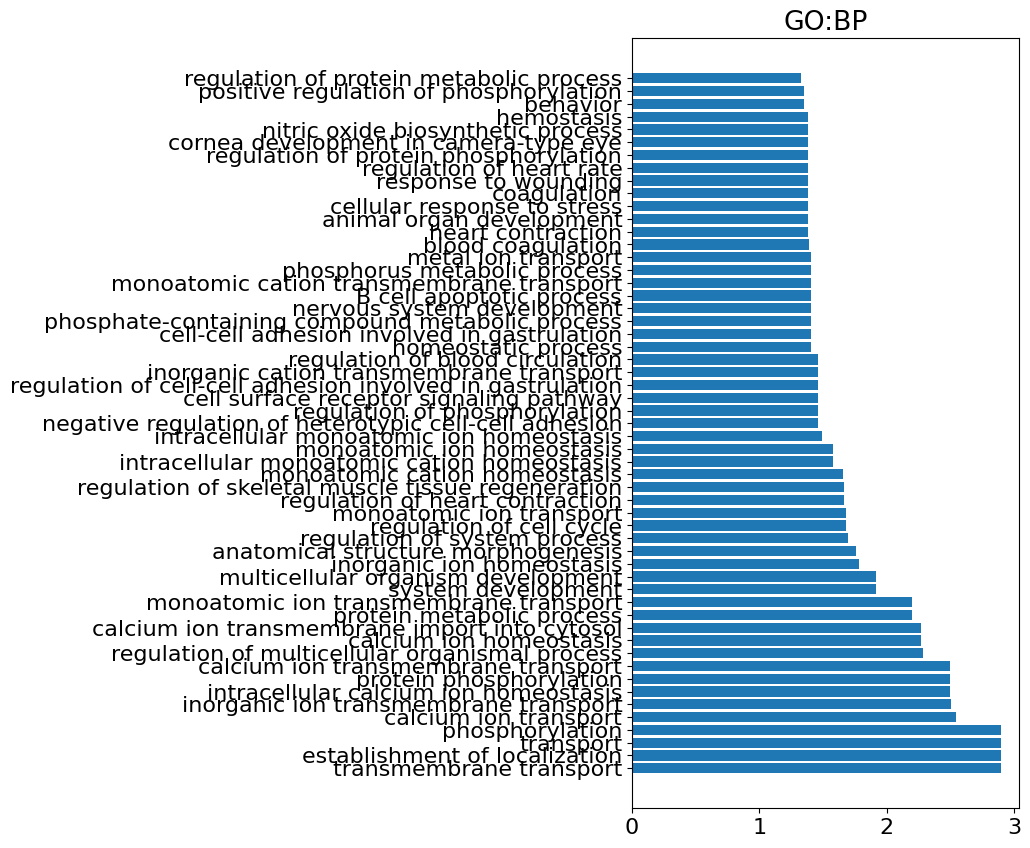

In [62]:
for s in set(enr_r.source):
    r=enr_r[enr_r.source==s]
    plt.figure(figsize=(5, 10))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)

## rat-specific network

In [95]:
enr_r_net = pd.DataFrame(gp.profile(organism='hsapiens',query=list(list(rat_only.index)),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_r_net=enr_r_net[(enr_r_net['term_size']<5000)&(enr_r_net['term_size']>5)]
enr_r_net=enr_r_net.sort_values('p_value')
if print_enr:
    print(f'enrichment for rat only network (n={len(list(rat_only.index))})')
    if (len(enr_r_net)>0):
        print(set(enr_r_net.name))
    else:
        print('NA')

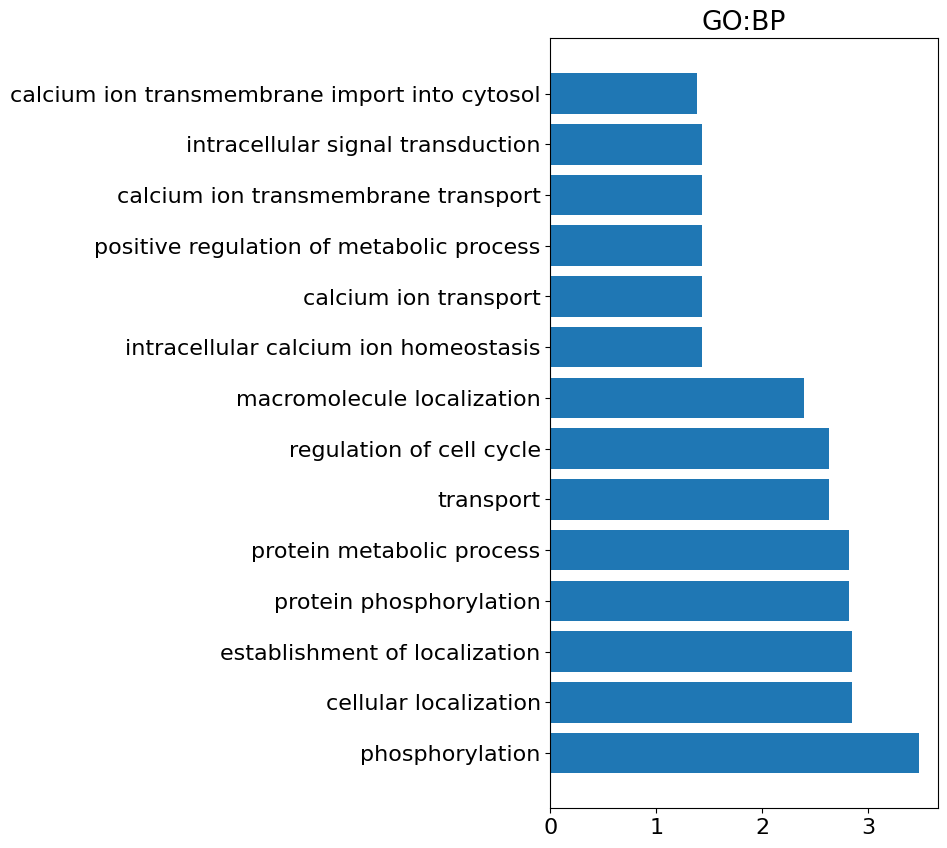

In [96]:
for s in set(enr_r_net.source):
    r=enr_r_net[enr_r_net.source==s]
    plt.figure(figsize=(5, 10))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)

## human seed

In [97]:
enr_h = pd.DataFrame(gp.profile(organism='hsapiens',query=list(seed_h),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_h=enr_h[(enr_h['term_size']<5000)&(enr_h['term_size']>5)]
enr_h=enr_h.sort_values('p_value', ascending=False)
if print_enr:
    print(f'enrichment for {label_h} (n={len(seed_h)})')
    if (len(enr_h)>0):
        print(set(enr_h.name))
    else:
        print('NA')

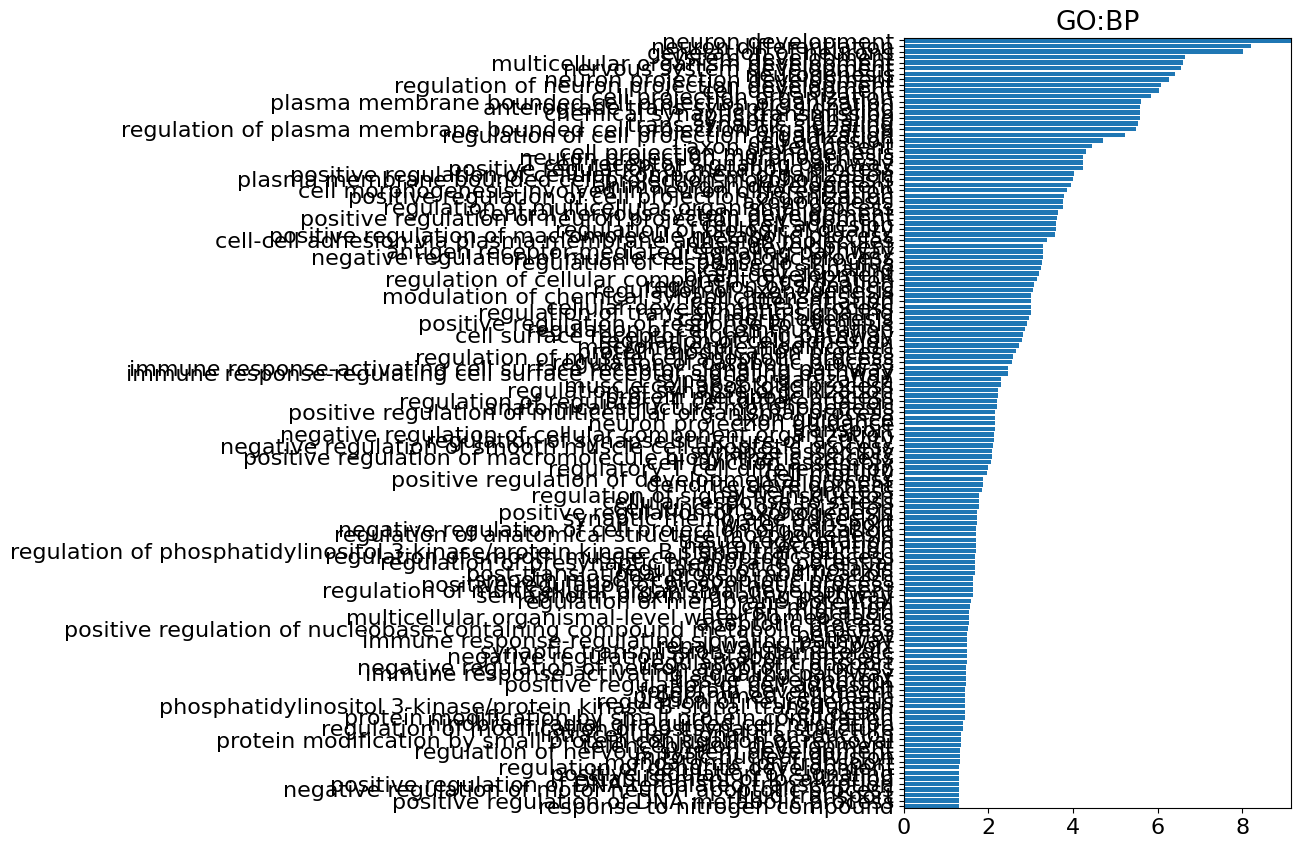

In [98]:
for s in set(enr_h.source):
    r=enr_h[enr_h.source==s]
    plt.figure(figsize=(5, 10))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)
    plt.margins(0)

## human-specific network

In [99]:
enr_h_net = pd.DataFrame(gp.profile(organism='hsapiens',query=list(list(hm_only.index)),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_h_net=enr_h_net[(enr_h_net['term_size']<5000)&(enr_h_net['term_size']>5)]
enr_h_net=enr_h_net.sort_values('p_value', ascending=False)
if print_enr:
    print(f'enrichment for human-specific network (n={len(list(hm_only.index))})')
    if (len(enr_h_net)>0):
        print(set(enr_h_net.name))
    else:
        print('NA')

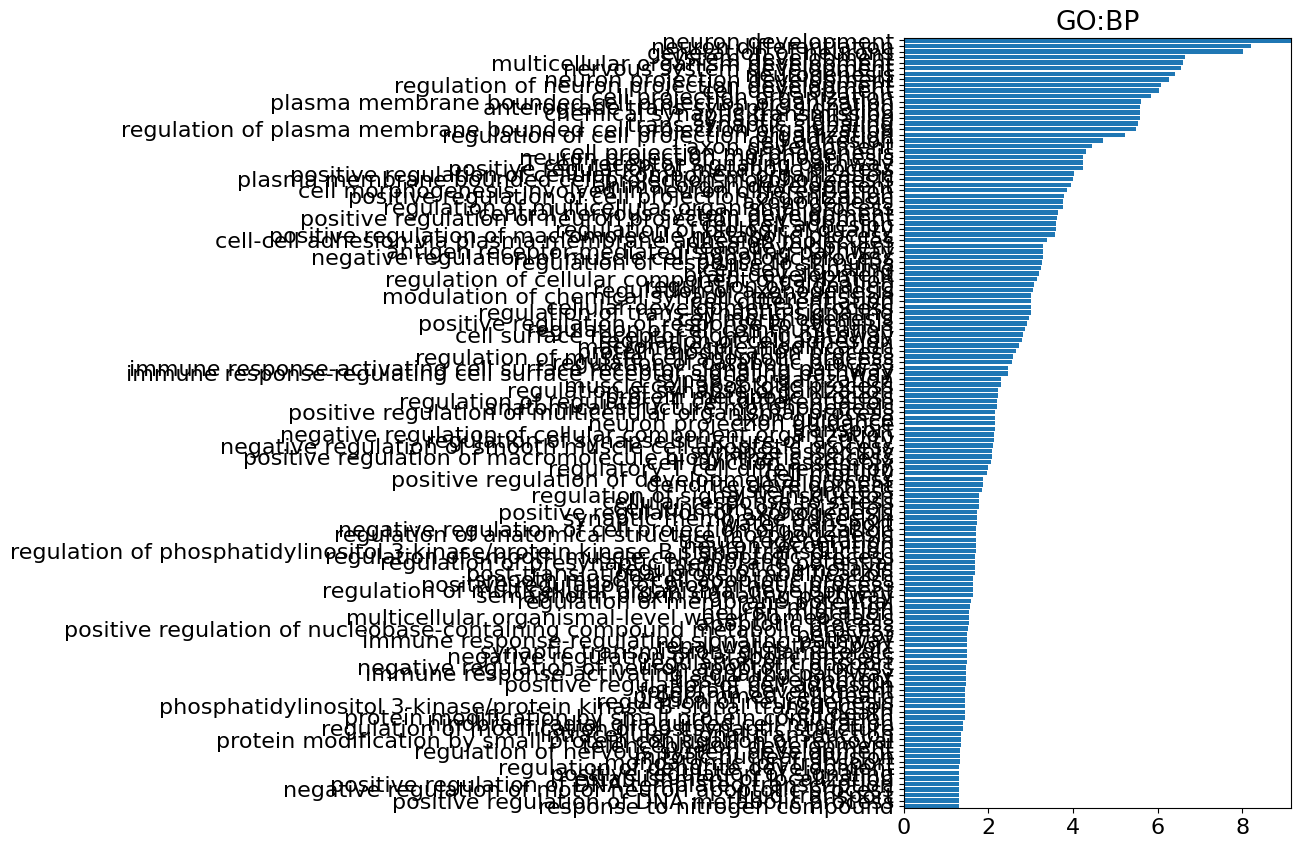

In [100]:
for s in set(enr_h.source):
    r=enr_h[enr_h.source==s]
    plt.figure(figsize=(5, 10))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)
    plt.margins(0)

## network genes

In [191]:
sns.color_palette('pastel6')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [67]:
enr_net = pd.DataFrame(gp.profile(organism='hsapiens',query=list(inNetwork.index),sources=['GO:BP'],significance_threshold_method='fdr'))
enr_net=enr_net[(enr_net['term_size']<5000)&(enr_net['term_size']>5)]
enr_net=enr_net.sort_values('p_value')
if print_enr:
    print(f'enrichment for {label_h} x {label_r} (n={len(inNetwork.index)})')
    if (len(results)>0):
        print(set(results.name))
    else:
        print('NA')

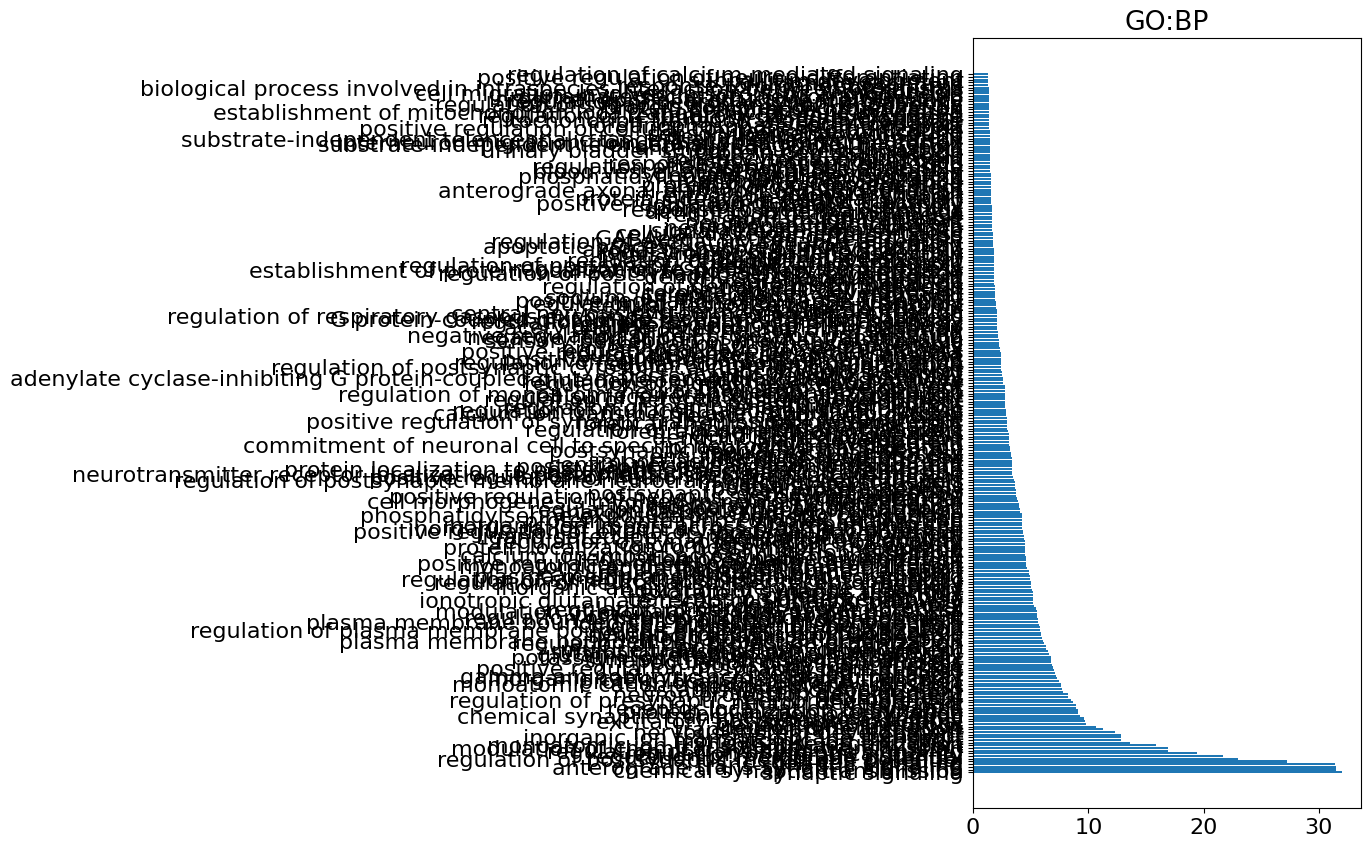

In [169]:
for s in set(enr_net.source):
    r=enr_net[enr_net.source==s]
    plt.figure(figsize=(5, 10))
    plt.barh(r.name,-np.log10(r.p_value))
    plt.title(label=s)

## compare across the 3

### venn diagram

In [113]:
save_fig

True

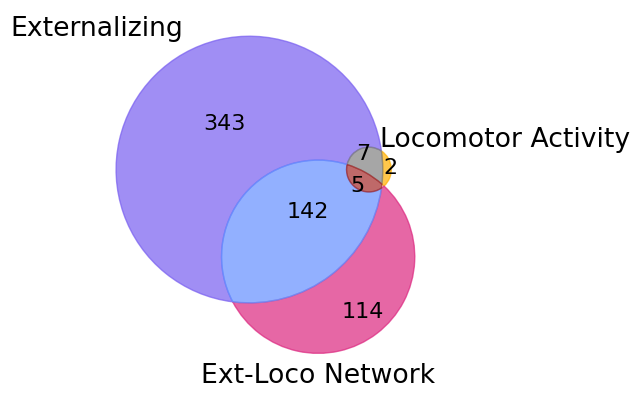

In [116]:
# Define the three sets of genes
set1 = set(enr_h_net.name)
set2 =set(enr_r_net.name)
set3 =set(enr_net.name)

# Create the Venn diagram
venn = venn3([set1, set2, set3], ('Externalizing', 'Locomotor Activity', 'Ext-Loco Network'),alpha=0.7)

colors = {
    '100': colour_dict['ext'], '010': colour_dict['loco'], '001': colour_dict['shared'],
    '110': 'grey', '101': colour_dict['ext_alt'], '011':colour_dict['loco_alt'], '111': 'brown'
}
for id_, color in colors.items():
    patch = venn.get_patch_by_id(id_)
    if patch:
        patch.set_color(color)

if save_fig:
    plt.savefig(f'figures/GOBP_enr_venn_single_species_network_vs_network_{label_r}_{label_h}.svg')

plt.show()


In [120]:
set(enr_h_net.name).intersection(enr_r_net.name).intersection(enr_net.name)

{'calcium ion transmembrane import into cytosol',
 'calcium ion transmembrane transport',
 'calcium ion transport',
 'establishment of localization',
 'transport'}

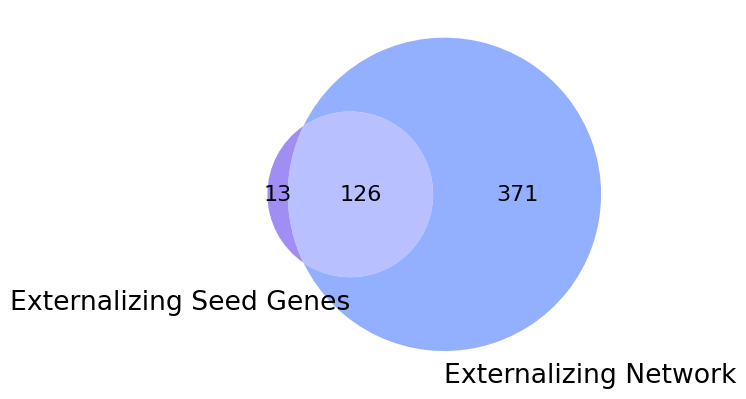

In [117]:
# Define the three sets of genes
set1 = set(enr_h.name)
set2 =set(enr_h_net.name)

# Create the Venn diagram
venn = venn2([set1, set2], ('Externalizing Seed Genes', 'Externalizing Network'),set_colors=(colour_dict['ext'], colour_dict['ext_alt']),alpha=0.7)

if save_fig:
    plt.savefig(f'figures/GOBP_enr_venn_single_species_vs_seed_{label_h}.svg')


In [111]:
set(enr_r.name)

{'B cell apoptotic process',
 'anatomical structure morphogenesis',
 'animal organ development',
 'behavior',
 'blood coagulation',
 'calcium ion homeostasis',
 'calcium ion transmembrane import into cytosol',
 'calcium ion transmembrane transport',
 'calcium ion transport',
 'cell surface receptor signaling pathway',
 'cell-cell adhesion involved in gastrulation',
 'cellular response to stress',
 'coagulation',
 'cornea development in camera-type eye',
 'establishment of localization',
 'heart contraction',
 'hemostasis',
 'homeostatic process',
 'inorganic cation transmembrane transport',
 'inorganic ion homeostasis',
 'inorganic ion transmembrane transport',
 'intracellular calcium ion homeostasis',
 'intracellular monoatomic cation homeostasis',
 'intracellular monoatomic ion homeostasis',
 'metal ion transport',
 'monoatomic cation homeostasis',
 'monoatomic cation transmembrane transport',
 'monoatomic ion homeostasis',
 'monoatomic ion transmembrane transport',
 'monoatomic ion 

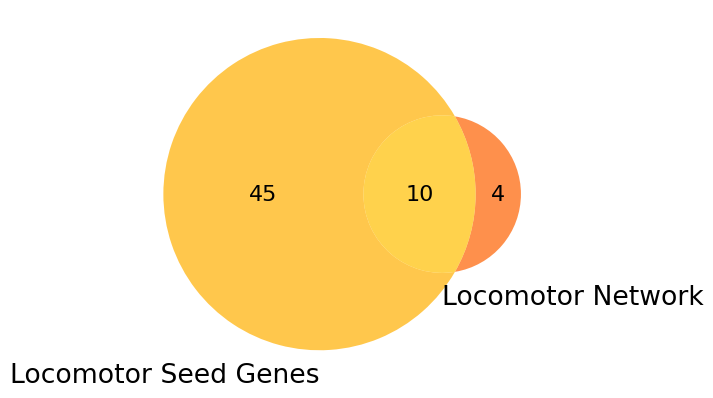

In [115]:
# Define the three sets of genes
set1 = set(enr_r.name)
set2 =set(enr_r_net.name)

# Create the Venn diagram
venn = venn2([set1, set2], ('Locomotor Seed Genes', 'Locomotor Network'),set_colors=(colour_dict['loco'], colour_dict['loco_alt']),alpha=0.7)

if save_fig:
    plt.savefig(f'figures/GOBP_enr_venn_single_species_vs_seed_{label_r}.svg')


### scatter- all overlap

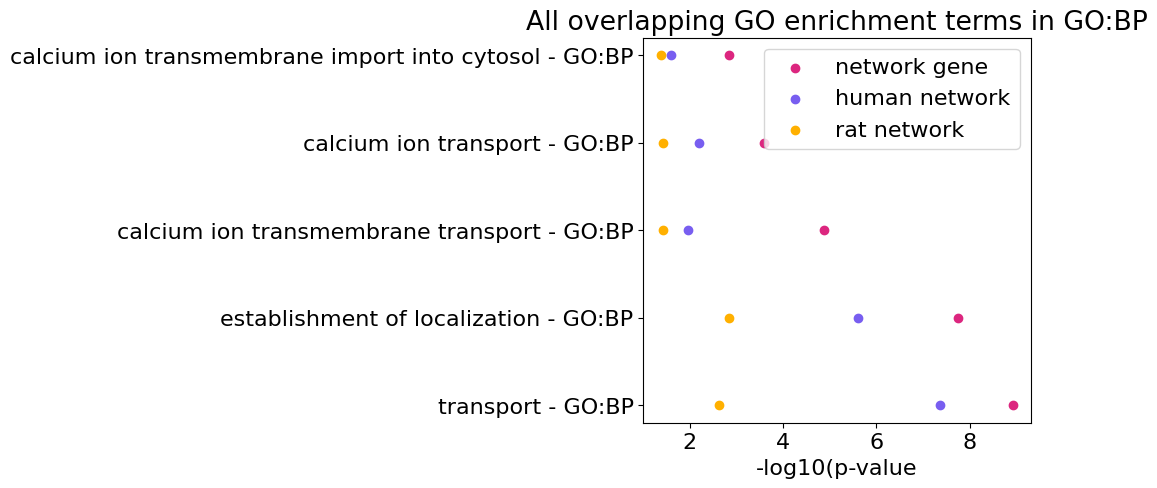

In [105]:
x=set(enr_net['name']).intersection(enr_r_net['name']).intersection(enr_h_net['name'])

s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r_net[(enr_r_net.name.isin(x))&(enr_r_net.source==s)]
h=enr_h_net[(enr_h_net.name.isin(x))&(enr_h_net.source==s)]



plt.figure(figsize=(5,5))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human network')
plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat network')
plt.xlabel('-log10(p-value')
plt.title(f'All overlapping GO enrichment terms in {s}')
plt.margins(0.05)
plt.legend()


# combined network w/o rat or human network

In [106]:
x=(set(enr_net['name']).difference(enr_r_net['name'])).difference(enr_h_net['name'])
x

{'G protein-coupled glutamate receptor signaling pathway',
 'GABAergic neuron differentiation',
 'acetylcholine receptor signaling pathway',
 'adenylate cyclase-inhibiting G protein-coupled glutamate receptor signaling pathway',
 'anterograde axonal transport',
 'anterograde axonal transport of mitochondrion',
 'apoptotic cell clearance',
 'apoptotic process involved in development',
 'axo-dendritic transport',
 'axonal transport',
 'axonal transport of mitochondrion',
 'blood vessel endothelial cell migration',
 'brainstem development',
 'calcium ion import',
 'calcium ion import across plasma membrane',
 'calcium ion import into cytosol',
 'cell migration involved in sprouting angiogenesis',
 'cellular response to acetylcholine',
 'commitment of neuronal cell to specific neuron type in forebrain',
 'dendritic spine maintenance',
 'dentate gyrus development',
 'endocytosis',
 'engulfment of apoptotic cell',
 'establishment of mitochondrion localization, microtubule-mediated',
 'establ

# rat network w/o human or shared network

In [240]:
x=(set(enr_r_net['name']).difference(enr_net['name'])).difference(enr_h_net['name'])
x

{'B cell apoptotic process',
 'B cell homeostasis',
 'blood coagulation',
 'calcium ion homeostasis',
 'calcium ion transport into cytosol',
 'cell-cell adhesion involved in gastrulation',
 'cellular homeostasis',
 'cellular localization',
 'coagulation',
 'cornea development in camera-type eye',
 'embryo development',
 'embryo development ending in birth or egg hatching',
 'embryonic morphogenesis',
 'heart contraction',
 'heart process',
 'hemostasis',
 'homeostatic process',
 'inorganic ion homeostasis',
 'intracellular calcium ion homeostasis',
 'intracellular chemical homeostasis',
 'intracellular monoatomic cation homeostasis',
 'intracellular monoatomic ion homeostasis',
 'monoatomic cation homeostasis',
 'monoatomic ion homeostasis',
 'negative regulation of heterotypic cell-cell adhesion',
 'nitric oxide biosynthetic process',
 'nitric oxide metabolic process',
 'phosphate-containing compound metabolic process',
 'phosphorus metabolic process',
 'phosphorylation',
 'platelet a

# human network w/o rat or shared network

In [107]:
x=(set(enr_h_net['name']).difference(enr_net['name'])).difference(enr_r_net['name'])
x

{'AV node cell action potential',
 'AV node cell to bundle of His cell communication',
 'AV node cell to bundle of His cell signaling',
 'ERBB4 signaling pathway',
 'L-amino acid transport',
 'L-ascorbic acid metabolic process',
 "RNA 3'-end processing",
 "RNA 5'-end processing",
 'SA node cell to atrial cardiac muscle cell communication',
 'T cell receptor signaling pathway',
 'acidic amino acid transport',
 'actin filament-based movement',
 'actin filament-based process',
 'actin-mediated cell contraction',
 'action potential propagation',
 'activation of GTPase activity',
 'adult behavior',
 'amino acid transport',
 'antigen processing and presentation via MHC class Ib',
 'antigen receptor-mediated signaling pathway',
 'apoptotic process',
 'associative learning',
 'atrial cardiac muscle cell action potential',
 'atrial cardiac muscle cell to AV node cell communication',
 'atrial cardiac muscle cell to AV node cell signaling',
 'auditory behavior',
 'autophagosome-lysosome fusion',


### human vs rat

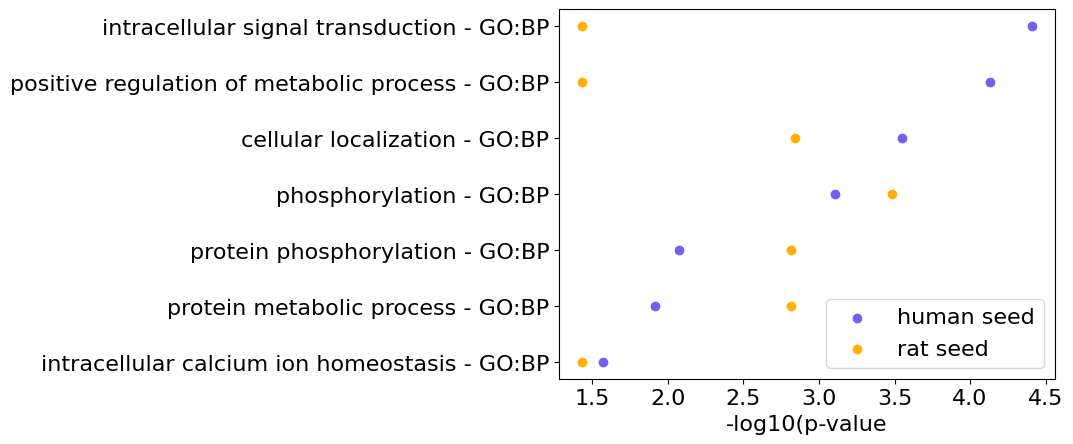

In [108]:
x=set(enr_h_net['name']).intersection(enr_r_net['name']).difference(enr_net['name'])
plt.scatter(y=enr_h_net[enr_h_net.name.isin(x)]['name']+' - '+ enr_h_net[enr_h_net.name.isin(x)]['source'],x=-np.log10(enr_h_net[enr_h_net.name.isin(x)]['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=enr_r_net[enr_r_net.name.isin(x)]['name']+' - '+ enr_r_net[enr_r_net.name.isin(x)]['source'],x=-np.log10(enr_r_net[enr_r_net.name.isin(x)]['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.legend()

### human vs network

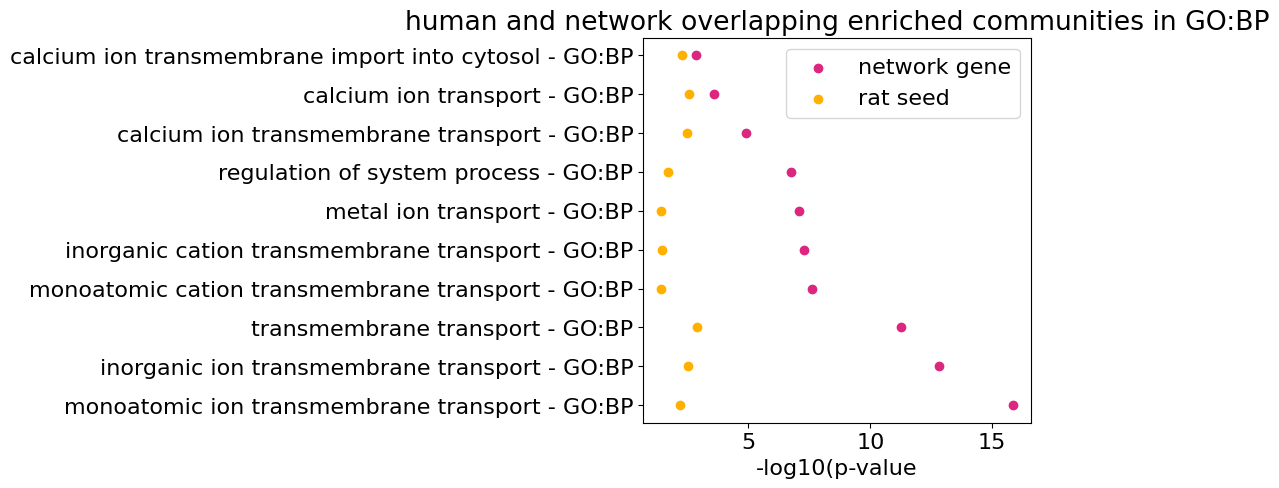

In [148]:
x=set(enr_net['name']).intersection(enr_r['name']).difference(enr_h['name'])
s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]


plt.figure(figsize=(5,5))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
#plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'human and network overlapping enriched communities in {s}')
plt.margins(0.05)
plt.legend()


### human vs network

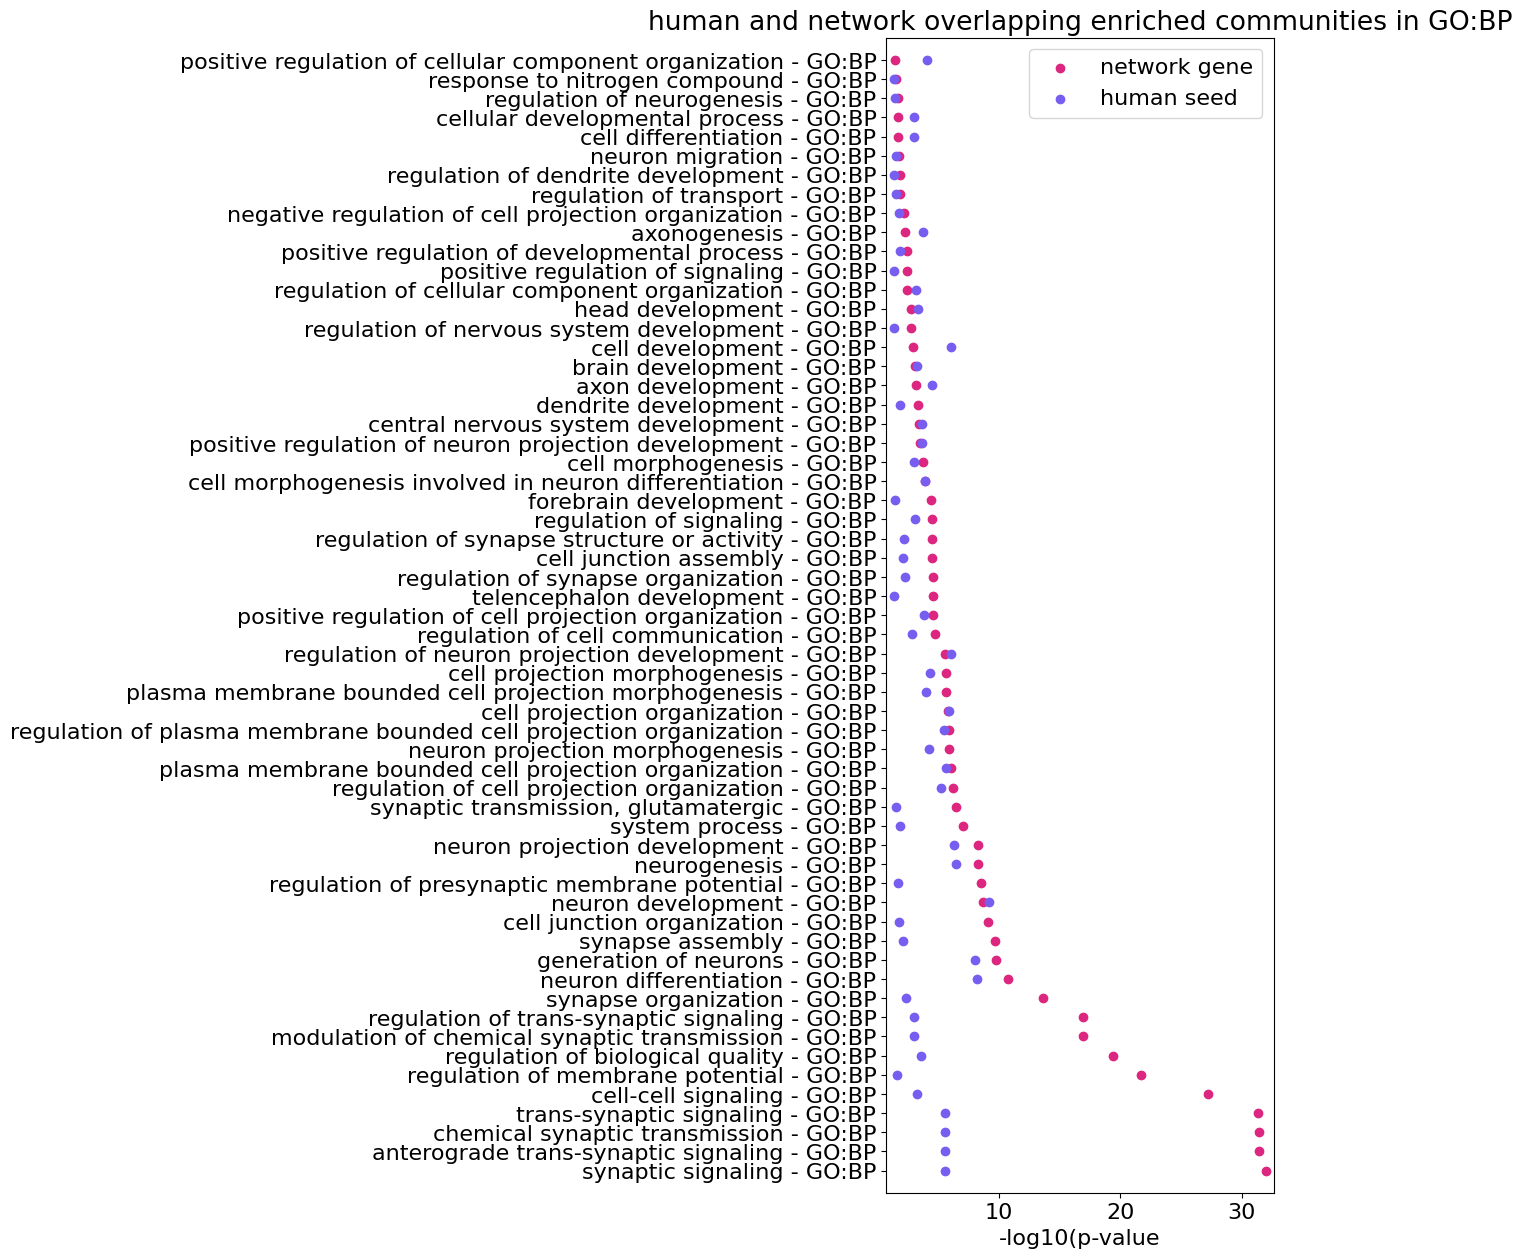

In [152]:
x=set(enr_net['name']).intersection(enr_h['name']).difference(enr_r['name'])
s='GO:BP'
n=enr_net[(enr_net.name.isin(x))&(enr_net.source==s)]
r=enr_r[(enr_r.name.isin(x))&(enr_r.source==s)]
h=enr_h[(enr_h.name.isin(x))&(enr_h.source==s)]


plt.figure(figsize=(5,15))
plt.scatter(y=n['name']+' - '+ n['source'],x=-np.log10(n['p_value']),color=colour_dict['shared'],label='network gene')
plt.scatter(y=h['name']+' - '+ h['source'],x=-np.log10(h['p_value']),color=colour_dict['ext'],label='human seed')
#plt.scatter(y=r['name']+' - '+ r['source'],x=-np.log10(r['p_value']),color=colour_dict['loco'],label='rat seed')
plt.xlabel('-log10(p-value')
plt.title(f'human and network overlapping enriched communities in {s}')
plt.margins(0.02)
plt.legend()


# compare the NPS scores for different cutoffs of seed genes

In [56]:
NPS_dict.keys()

dict_keys(['loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_subsample_PCNet2.0'])

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. subsample')

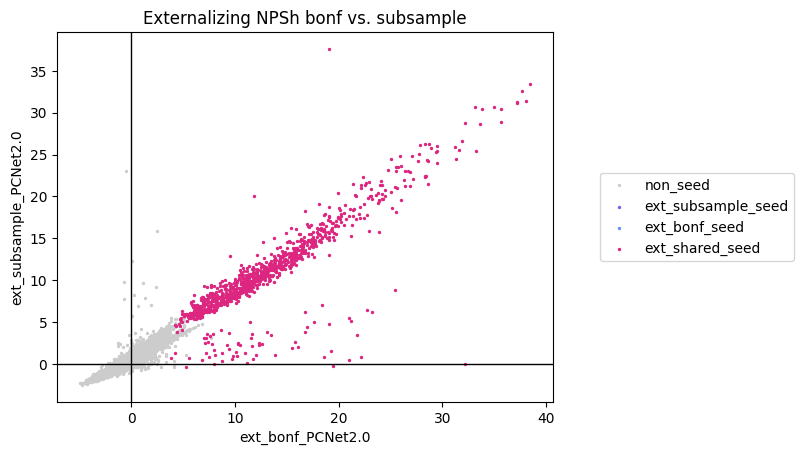

In [58]:
cutx='bonf'
cuty='subsample'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. top500')

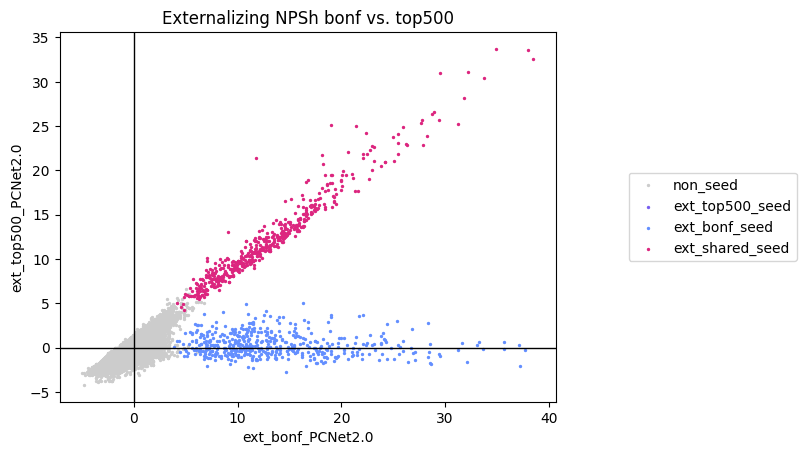

In [59]:
cutx='bonf'
cuty='top500'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh top500 vs. subsample')

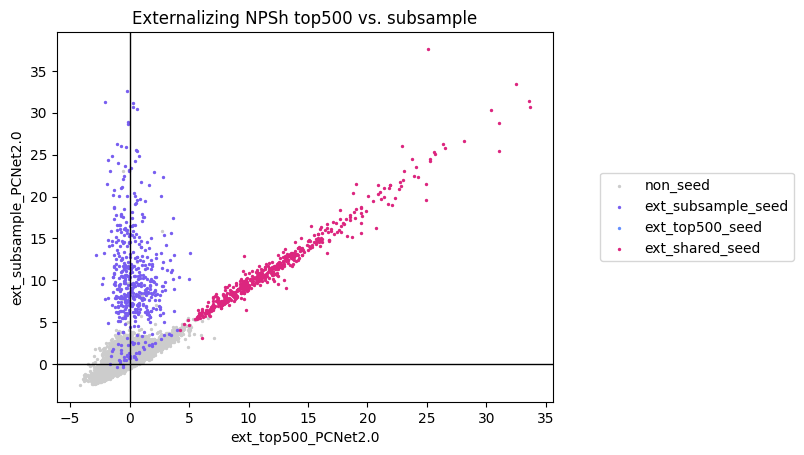

In [60]:
cutx='top500'
cuty='subsample'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)

Text(0.5, 1.0, 'Externalizing NPSh bonf vs. FDR')

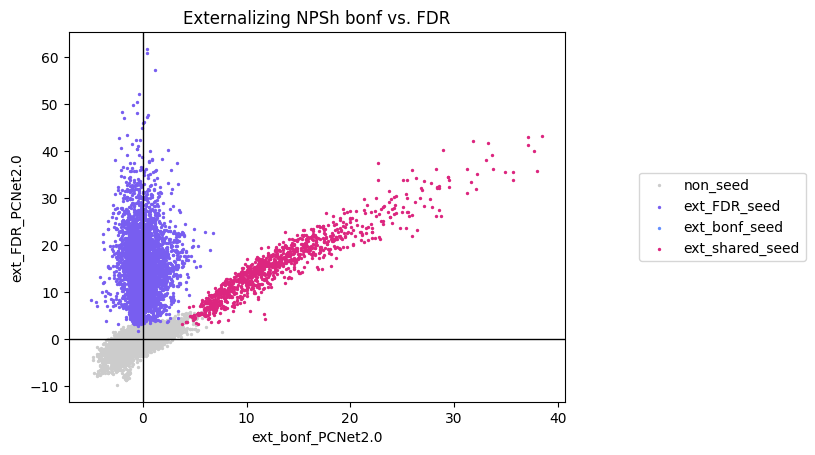

In [61]:
cutx='bonf'
cuty='FDR'
x_lab=trait_h+'_'+cutx+'_'+interactome_name
y_lab=trait_h+'_'+cuty+'_'+interactome_name


plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['other'],label='non_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext'],label='ext_'+cuty+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][~(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['ext_alt'],label='ext_'+cutx+'_seed',s=2)
plt.scatter(x=NPS_dict[x_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            y=NPS_dict[y_lab][(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cuty]))&(NPS_dict[y_lab].index.isin(seed_dict[trait_h+'_'+cutx]))],
            color=colour_dict['shared'],label='ext_shared_seed',s=2)

plt.axvline(x=0, color='black', linestyle='solid', linewidth=1)
plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.title('Externalizing NPSh '+cutx+' vs. '+cuty)